In [1]:
import openmc
import openmc.mgxs as mgxs
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
sys.path.insert(1, '../scripts')
import knp_analysis as ka
#sys.path.insert(1, '../../../fhr-benchmark-1/scripts')
#import openmc_analysis as oa

In [2]:
sp = openmc.StatePoint("./openmc_continuous_948K/statepoint.80.h5", autolink=False)
sp_mg = openmc.StatePoint("./openmc_mgxs/statepoint.80.h5", autolink=False)
df_moltres = pd.read_csv("./moltres/benchmark_moltres_csv.csv")

In [3]:
# KEFF 

In [4]:
sp_keff = sp.k_combined
sp_keff.n

1.3985044881322906

In [5]:
sp_keff.s

0.0012607366785466056

In [6]:
sp_mg_keff = sp_mg.k_combined

In [7]:
sp_mg_keff.s

0.0011520224868877694

In [8]:
keff_moltres = list(df_moltres["Executioner/eigenvalue"])[-1]
keff_moltres

1.4027376845842

In [9]:
(keff_moltres - sp_keff.n)*1e5

423.3196451909338

In [10]:
def reactivity(keff):
    return (keff-1)/keff

In [11]:
pd_keff = {"openmc no hom": sp_keff.n, "openmc hom": sp_mg_keff.n, "moltres": keff_moltres}
pd_diff = {"openmc no hom": 0, "openmc hom": (sp_mg_keff.n-sp_keff.n)*1e5, "moltres": (keff_moltres-sp_keff.n)*1e5}
pf_norm_diff = {"openmc no hom": 0, "openmc hom": (sp_mg_keff.n-sp_keff.n)/sp_keff.n*1e5, "moltres": (keff_moltres-sp_keff.n)/sp_keff.n*1e5}
reactivity_val = {"openmc no hom": reactivity(sp_keff.n)*1e5, "openmc hom": reactivity(sp_mg_keff.n)*1e5, "moltres": reactivity(keff_moltres)*1e5}
reactivity_err = {"openmc no hom": sp_keff.s/sp_keff.n**2*1e5, "openmc hom": sp_mg.k_combined.s/sp_mg.k_combined.n**2*1e5, "moltres": 0}
reactivity_diff = {"openmc no hom": 0, "openmc hom": (reactivity(sp_mg_keff.n)-reactivity(sp_keff.n))*1e5, "moltres": (reactivity(keff_moltres)-reactivity(sp_keff.n))*1e5}

data = [pd_keff, pd_diff, pf_norm_diff, reactivity_val, reactivity_err, reactivity_diff]
df_keff_results = pd.DataFrame(data, index =['keff', 'keff diff', 'keff norm diff', 'reactivity [pcm]', 'reactivity_err', 'reactivity diff [pcm]'])



In [12]:
df_keff_results = df_keff_results.transpose()
df_keff_results

,keff,keff diff,keff norm diff,reactivity [pcm],reactivity_err,reactivity diff [pcm]
openmc no hom,1.398504,0.000000,0.000000,28495.045351,64.460944,0.000000
openmc hom,1.398373,-13.133375,-9.391014,28488.329680,58.913497,-6.715671
moltres,1.402738,423.319645,302.694520,28710.833751,0.000000,215.788400


In [13]:
# BETA 
beta_openmc = ka.get_beta(sp)*1e5
beta_openmc

653.4062253411388

In [14]:
df_no_delayed = pd.read_csv("./moltres/benchmark_moltres_csv.csv")
keff_moltres_no_delayed = list(df_no_delayed["Executioner/eigenvalue"])[-1]
beta_moltres = (keff_moltres-keff_moltres_no_delayed)/keff_moltres*1e5
beta_moltres

0.0

In [15]:
pd_beta = {"openmc": round(beta_openmc,1), "moltres": round(beta_moltres,2)}
pd_beta_diff = {"openmc": 0, "moltres":round(beta_moltres-beta_openmc,2)}
data = [pd_beta, pd_beta_diff]
df_beta = pd.DataFrame(data, index =['beta', 'beta diff'])

In [16]:
df_beta = df_beta.transpose()
df_beta

,beta,beta diff
openmc,653.4,0.00
moltres,0.0,-653.41


In [17]:
# TEMP COEFF 

In [18]:
sp_1100K = openmc.StatePoint('./openmc_continuous_1100K/statepoint.80.h5', autolink=False)
keff_openmc_1100K = sp_1100K.k_combined
tc_openmc = ka.reactivity_coefficient_b(sp_keff.n,sp_keff.s, keff_openmc_1100K.n, keff_openmc_1100K.s, (1100-948))

In [19]:
df_1100K = pd.read_csv("./moltres_nodnp/benchmark_moltres_csv.csv")
keff_moltres_1100 = list(df_1100K["Executioner/eigenvalue"])[-1]
tc_moltres = ka.reactivity_coefficient_b(keff_moltres,0 , keff_moltres_1100, 0, (1100-948))

In [20]:
pd_tc =  {"openmc": round(tc_openmc[0],2), "moltres": round(tc_moltres[0],2)}
pd_tc_diff = {"openmc": 0, "moltres": round(tc_moltres[0]-tc_openmc[0],2)}
data = [pd_tc, pd_tc_diff]
df_tc = pd.DataFrame(data, index =['temp coeff', 'diff'])

In [21]:
df_tc = df_tc.transpose()
df_tc

,temp coeff,diff
openmc,-3.63,0.00
moltres,-4.06,-0.43


In [22]:
# FLUX 

In [23]:
def get_values(sp_file):
    tally_flux = sp_file.get_tally(name='flux')
    flux = tally_flux.get_slice(scores=['flux'])
    nu_fission = tally_flux.get_slice(scores=['nu-fission'])
    fission = tally_flux.get_slice(scores=['fission'])
    flux_conv_dict = {}
    eg_names = ['eg4', 'eg3', 'eg2', 'eg1']
    egs = [(1e-6, 1.8554), (1.8554, 2.9023e1), (2.9023e1, 9.1188e3), (9.1188e3, 2.0e7)]
    flux_eg, nu = {}, {}
    for x in range(4):
        print(x)
        flux_eg[x] = flux.get_slice(
            filters=[
                openmc.EnergyFilter], filter_bins=[
                (egs[x],)])
        nu_fiss_eg = nu_fission.get_slice(
            filters=[
                openmc.EnergyFilter], filter_bins=[
                (egs[x],)])
        fiss_eg = fission.get_slice(
            filters=[
                openmc.EnergyFilter], filter_bins=[
                (egs[x],)])
        nu[x] = sum(nu_fiss_eg.mean) / sum(fiss_eg.mean)
    return flux_eg, nu

In [24]:
flux_eg, nu = get_values(sp)

0
1
2
3


In [25]:
nu

{0: array([[2.43670002]]),
 1: array([[2.4365711]]),
 2: array([[2.43452954]]),
 3: array([[2.58724155]])}

In [26]:
df_flux = pd.read_csv("./moltres/benchmark_moltres_csv_flux_centerline_0003.csv")

In [27]:
def get_flux_dict(k, P, z_thickness):
    Q = 200 * 1.6022e-13
    #V = 3 * np.sqrt(3) / 2 * 27.01**2 * z_thickness / (100*300)
    Lx, Ly = 27.1, 23.4
    V = Lx*2 * Ly*2 * z_thickness / (100*1000)
    flux_conv_dict = {}
    eg_names = ['eg4', 'eg3', 'eg2', 'eg1']
    for x in range(4):
        N = P * nu[x] / (Q * k)
        flux_conv_dict[eg_names[x]] = flux_eg[x].mean * 1 / V * N
        flux_conv_dict[eg_names[x]].shape = (1000, 100)
        flux_conv_dict[eg_names[x]][np.isnan(flux_conv_dict[eg_names[x]])] = 0
    return flux_conv_dict

In [28]:
power_moltres = 26223
flux_vals_openmc_1 = get_flux_dict(sp_keff.n, power_moltres, z_thickness=1)
flux_vals_openmc_185 = get_flux_dict(sp_keff.n, power_moltres*1.85, z_thickness=1.85)

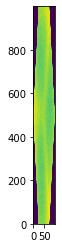

In [29]:
plt.figure()
plt.imshow(flux_vals_openmc_1["eg4"]/np.mean(flux_vals_openmc_1["eg4"]),
           interpolation='none',origin='lower',cmap='viridis')

In [30]:
def plot_flux_comparisons(group, flux_vals, df, name):
    moltres = np.array(list(df["group"+str(group)]))
    openmc = np.array(flux_vals['eg'+str(group)][:,50])
    perc_diff = list((moltres-openmc) /openmc * 100)
    #print(perc_diff)
    abs_perc_diff = list(abs(np.array(perc_diff)))
    max_val = max(abs_perc_diff)
    max_index = abs_perc_diff.index(max_val)
    print(perc_diff[max_index], max_index)
    norm_2 = np.linalg.norm(np.array(perc_diff))/len(moltres)
    print(norm_2)
    fig, ax = plt.subplots(figsize=(7,5))
    ax.plot(list(df['y']), flux_vals['eg'+str(group)][:,50], label='openmc TRISO fidelity')
    ax.plot(list(df['y']) , np.array(list(df['group'+str(group)])), label='moltres spatially homogenized')
    handles, labels = ax.get_legend_handles_labels()
    if group == 4:
        y = 0.3
    else:
        y = 1
    ax.legend(handles, labels, bbox_to_anchor=(1, y), fontsize=14)
    ax.set_xlabel('Slab y-direction [cm]', fontsize=16)
    ax.set_ylabel(r'Flux [$n/cm^2s$]', fontsize=16)
    ax.set_ylim(1.5e13, 1.5e14)
    ax.set_yscale('log')
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_xlim(-23.4, 23.4)
    ax.set_yticks([0.2e14, 0.4e14, 0.6e14, 0.8e14, 1e14, 1.2e14, 1.4e14])
    ax.set_title('Group '+str(group), fontsize=16)
    ax.grid()
    plt.savefig(name, bbox_inches='tight')

-10.577734954296945 907
0.13083265086713192


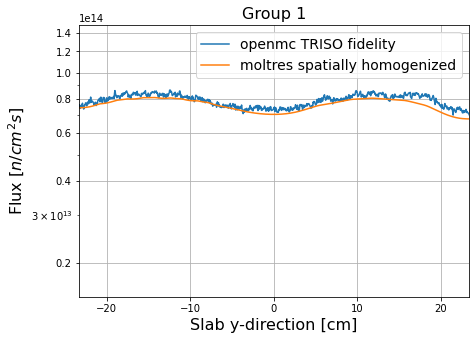

In [31]:
plot_flux_comparisons(1, flux_vals_openmc_1, df_flux, 'flux_group1_948K_full_assem')

7.5843944935487375 774
0.0855549107276457


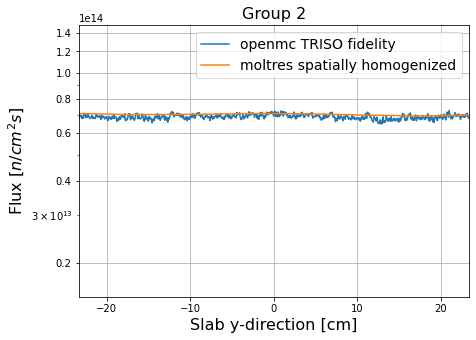

In [32]:
plot_flux_comparisons(2, flux_vals_openmc_1, df_flux, 'flux_group2_948K_full_assem')

8.958100077109494 228
0.10508260455584818


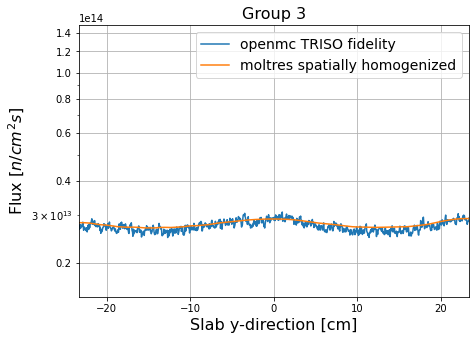

In [33]:
plot_flux_comparisons(3, flux_vals_openmc_1, df_flux, 'flux_group3_948K_full_assem')

6.9704680211038 543
0.09809027370391148


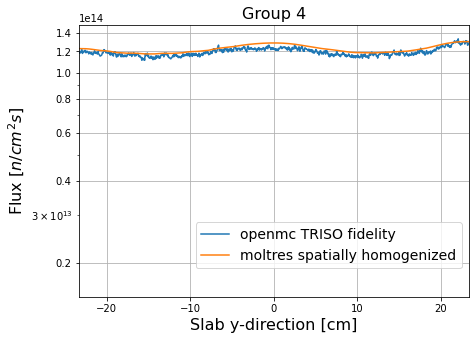

In [34]:
plot_flux_comparisons(4, flux_vals_openmc_1, df_flux, 'flux_group4_948K_full_assem')

In [35]:
# SPECTRUM

In [36]:
bins, engs = ka.generate_bins()

In [37]:
def flux_conv_full_assem(df, k, P):
    Q = 200 * 1.6022e-13  # J/fission
    nu_fission = np.array(
        df[df['score'].str.match('nu-fission')]['mean'])  # n/src
    fission = np.array(df[df['score'] == 'fission']['mean'])  # fission/src
    og_flux = np.array(df[df['score'].str.match('flux')]['mean'])  # n*cm/src
    nu = nu_fission / fission  # n/fission
    N = P * nu / (Q * k)  # src/s
    V = 632 * 3# 3 * np.sqrt(3) / 2 * (pc.H_side_big**2)
    #Lx, Ly = 27.1, 23.4
    #V = Lx*2 * Ly*2
    flux = 1 / V * N * og_flux  # n/(cm2*s)
    return flux

In [38]:
def get_252_spectrum_full_assem(sp_file, k, P):
    tally_spectrum_all = sp_file.get_tally(name='spectrum all')
    df_spectrum_all = tally_spectrum_all.get_pandas_dataframe()
    index_list = []
    for x in range(252):
        index_list += ['E' + str(x + 1)]
    df_ff = pd.DataFrame(index=index_list)
    df_ff['flux'] = flux_conv_full_assem(df_spectrum_all, k, P)
    fluxvals = np.append(np.array(df_ff['flux'])[0], np.array(df_ff['flux']))
    return fluxvals

In [39]:
def get_4_spectrum_full_assem(sp_file, k, P):
    tally_spectrum_4 = sp_file.get_tally(name='spectrum 4 groups')
    df_spectrum_4 = tally_spectrum_4.get_pandas_dataframe()
    index_list = []
    for x in range(4):
        index_list += ['E' + str(x + 1)]
    df_ff = pd.DataFrame(index=index_list)
    df_ff['flux'] = flux_conv_full_assem(df_spectrum_4, k, P)
    fluxx = np.array(df_ff['flux'])/ bins
    fluxvals = np.append(fluxx[0], fluxx)
    return fluxvals

In [40]:
spectrum_252 = get_252_spectrum_full_assem(sp, sp_keff.n, power_moltres)
spectrum_4 = get_4_spectrum_full_assem(sp, sp_keff.n, power_moltres)
groups_4 = [1e-6, 1.8554, 2.9023e1, 9.1188e3, 2.0e7]

In [41]:
moltres_spectrum = np.array([
                    list(df_moltres["group4_flux"])[-1], 
                    list(df_moltres["group3_flux"])[-1],
                    list(df_moltres["group2_flux"])[-1],
                    list(df_moltres["group1_flux"])[-1]]) / bins
moltres = np.append(moltres_spectrum[0], moltres_spectrum)

In [42]:
moltres

array([1.60864484e+12, 1.60864484e+12, 6.08993276e+11, 1.00237544e+12,
       1.30745048e+12])

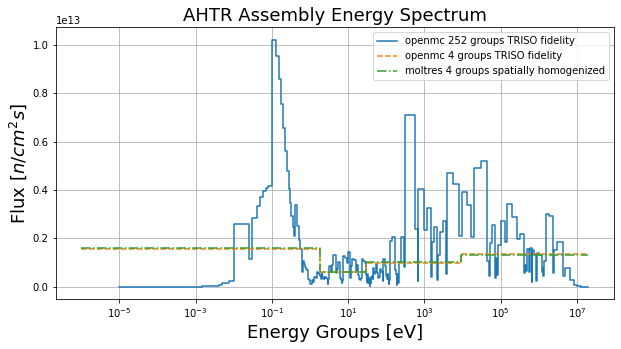

In [43]:
fig, ax = plt.subplots(figsize=(10,5))
ax.semilogx(np.array(engs) , spectrum_252, drawstyle='steps', label='openmc 252 groups TRISO fidelity')
#ax.semilogx(groups_4 , spectrum_4_mg, drawstyle='steps', label='openmc 4 groups spatially homogenized')
ax.semilogx(groups_4 , spectrum_4, '--', drawstyle='steps', label='openmc 4 groups TRISO fidelity')
ax.semilogx(groups_4 , moltres, '-.', drawstyle='steps', label='moltres 4 groups spatially homogenized')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, bbox_to_anchor=(1, 1))
ax.set_xlabel('Energy Groups [eV]', fontsize=18)
ax.set_ylabel(r'Flux [$n/cm^2s$]', fontsize=18)
ax.set_title('AHTR Assembly Energy Spectrum', fontsize=18)
ax.grid()
plt.savefig('neutron_spectrum_948K_full_assem', dpi=300)